### Sponsors Regression analysis

Regression analysis to try and understand more the effect of sponsors on the popularity of a video.

In [1]:
# FINDSPARK
import findspark
findspark.init()

# BASIC IMPORTS
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import ttest_ind, ttest_rel

import statsmodels.api as sm
import statsmodels.formula.api as smf

import networkit as nk

# PYSPARK
from pyspark.sql.functions import col, udf, explode, when, collect_list, size, mean
from pyspark.sql.column import Column, _to_java_column
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g') # Increase the driver memory to avoid HeapOverflow when repartitioning.
config.set('spark.driver.maxResultSize', '16g')
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution.
spark = SparkSession(sc)

plt.style.use('ggplot')

In [2]:
PATH_ALL_METADATAS_SRC = '../data/generated/all_metadatas_en.parquet'
PATH_ANALYSIS_DF = '../data/generated/sponsor_regression_df.parquet'

In [3]:
all_metadatas = spark.read.parquet(PATH_ALL_METADATAS_SRC)

In [4]:
all_metadatas = all_metadatas \
    .withColumn('like_view_ratio', col('like_count') / col('view_count')) \
    .withColumn('dislike_view_ratio', col('dislike_count') / col('view_count')) \
    .withColumn('like_dislike_ratio', col('like_count') / col('dislike_count'))

all_metadatas = all_metadatas \
    .where(col('like_view_ratio').isNotNull()) \
    .where(col('dislike_view_ratio').isNotNull()) \
    .where(col('like_dislike_ratio').isNotNull())

In [5]:
all_metadatas.dtypes

[('display_id', 'string'),
 ('domains', 'array<string>'),
 ('domain_categories', 'array<string>'),
 ('is_sponsored', 'boolean'),
 ('categories', 'string'),
 ('channel_id', 'string'),
 ('crawl_date', 'date'),
 ('description', 'string'),
 ('dislike_count', 'int'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('diff_month', 'int'),
 ('like_view_ratio', 'double'),
 ('dislike_view_ratio', 'double'),
 ('like_dislike_ratio', 'double')]

In [7]:
df_reg = all_metadatas.select('is_sponsored', 'like_view_ratio')

In [9]:
# Run this cell to write the parquet file regression_urls with the columns you want to fit on :
all_metadatas.write.parquet(PATH_ANALYSIS_DF)

In [10]:
import pyarrow.parquet as pq
import statsmodels.formula.api as smf

class DataSet(dict):
    def __init__(self, path):
        self.parquet = pq.ParquetDataset(path)

    def __getitem__(self, key):
        try:
            return self.parquet.read([key]).to_pandas()[key]
        except:
            raise KeyError

pd_df_reg = DataSet(PATH_ANALYSIS_DF)

In [11]:
pd_df_reg["is_sponsored"] = pd_df_reg["is_sponsored"].astype(int)

In [13]:
mod = smf.ols('like_view_ratio ~ C(is_sponsored)', data=pd_df_reg)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        like_view_ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4707.
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:45:52   Log-Likelihood:            -5.1947e+06
No. Observations:            25585154   AIC:                         1.039e+07
Df Residuals:                25585152   BIC:                         1.039e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

We observe that the p-values and confidence intervals are coherent (p-value < 0.05); If we take the entire dataset, we observe that in average we have : ${LikePerView = 0.0212 + IsSponsored*0.0096}$ 


We can thus see that on average the fact that a video is sponsored account for $\frac{0.0096}{0.0212}*100 = 45$% of the likes per view on a video if we consider this simple model. 


Although we get a pretty positive analysis for the effect of sponsorship on videos we still need to keep in mind that we are only using a simple model and that lots of non-identified confounder could have some impact on the "popularity" metrics we use, just as a simple exemple we could take a look at the "popularity" of creator that tells their audience to "like, comment and subscribe" versus those that don't.

Another key point that needs to be talked upon is akin to the question of the egg and the chicken, is the fact that sponsored videos tends to do better than un-sponsored one because the creator was already popular at the beginning or because sponsors have a significant effects, we will now try to see the effet at the individual channel level.

In [14]:
#Since we will work at the channel level, we groupby each individual channel (defined by its id)
gb_channel = all_metadatas.groupby('channel_id')

In [15]:
list_channel = []
list_channel = all_metadatas.select('channel_id').distinct().collect()
len(list_channel)

115941

In [35]:
all_metadatas_pd = all_metadatas.select('is_sponsored', 'like_view_ratio', 'channel_id') \
    .toPandas()
all_metadatas_pd["is_sponsored"] = all_metadatas_pd["is_sponsored"].astype(int)

all_metadatas_pd

,is_sponsored,like_view_ratio,channel_id
0,0,0.002967,UCarI394EclOjlRrm6dUU5Yw
1,0,0.039630,UCAR3h_9fLV82N2FH4cE4RKw
2,0,0.154614,UCOy6tj7wcFiBOrW2oVsOF7Q
3,0,0.022042,UCwiaPYufmQOq5F1TI-FzQhw
4,0,0.009409,UChHBLdA2z3_PNDXYWfLCAmQ
...,...,...,...
25585149,1,0.052764,UCmRm1xtLIpBhuWjTyD411pA
25585150,1,0.005825,UCsaoYBUHz_lVB_dOmFwA9Zw
25585151,0,0.024965,UCi5HeQ29ohu60PUIN8CZmqA
25585152,0,0.030554,UCthjjEowaInDmJsrT-Mn3xQ


In [ ]:
# Now we do the regression based on the datas for each channel to get the coefficient we want
list_coeff = []
for channel in list_channel: 
    reg_channel = all_metadatas_pd[all_metadatas_pd.channel_id == channel[0]].copy()
    reg_channel["is_sponsored"] = reg_channel["is_sponsored"].astype(int)

    mod = smf.ols('like_view_ratio ~ C(is_sponsored)', data=reg_channel)
    np.random.seed(2)
    res = mod.fit()

    if len(res.params.values) > 1: # some channels only have sponsored or non-sponsored videos but not both
        list_coeff.append(res.params.values[1])

# We plot the distribution of the coefficients
plt.hist(list_coeff, bins=100)
plt.show()

In [53]:
# Remove outliers
list_coeff_std = np.std(list_coeff)
list_coeff_mean = np.mean(list_coeff)
list_coeff_clean = [x for x in list_coeff if x < list_coeff_mean + 3*list_coeff_std]

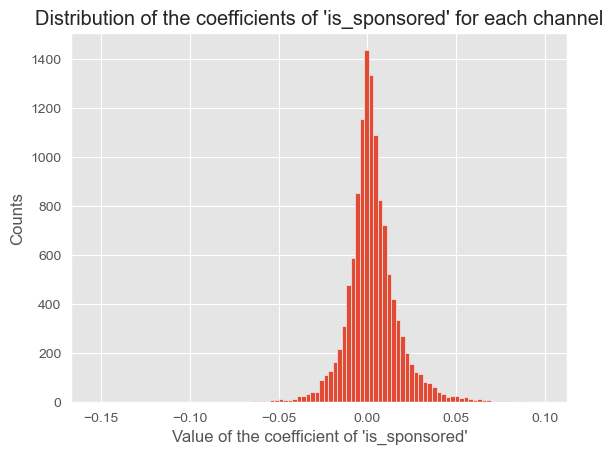

In [76]:
plt.style.use('ggplot')

plt.hist(list_coeff_clean, bins=100)
plt.title("Distribution of the coefficients of 'is_sponsored' for each channel")
plt.xlabel("Value of the coefficient of 'is_sponsored'")
plt.ylabel("Counts")
plt.show()

In [57]:
# Check if it is a laplacian distribution
stats.kstest(list_coeff, 'laplace')

KstestResult(statistic=0.47237026544940036, pvalue=0.0)

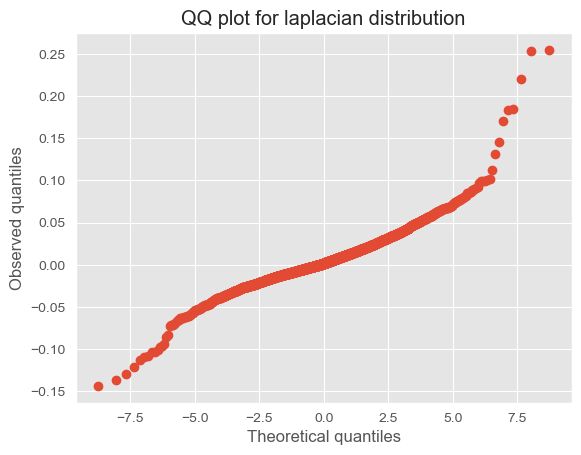

In [61]:
from scipy.stats import laplace

## plot qqplot for list_coeff laplacian distribution
plt.figure()
plt.title('QQ plot for laplacian distribution')
plt.ylabel('Observed quantiles')
plt.xlabel('Theoretical quantiles')

theoretical_quantiles = laplace.ppf(np.linspace(0, 1, len(list_coeff)))
observed_quantiles = np.sort(list_coeff)
plt.plot(theoretical_quantiles, observed_quantiles, 'o')

The distribution of the slope of the regression line seems to follow a **Laplace distribution**.

In [75]:
print(f"The mean of the slope of the regression line is {np.mean(list_coeff):.2}")
mean_like_view_ratio_nsp = all_metadatas_pd[all_metadatas_pd.is_sponsored == 0].like_view_ratio.mean()
print(f"The mean of the like_view_ratio for non-sponsored videos is {mean_like_view_ratio_nsp:.2}")
np.mean(list_coeff)/mean_like_view_ratio_nsp

The mean of the slope of the regression line is 0.0032
The mean of the like_view_ratio for non-sponsored videos is 0.022


0.14466702934259612

In general, channels have an increase of $14.47\%$ in the like_view_ratio when they post a sponsored video.